In [164]:
from Pipeline import BLEPipeline, WifiPipeline

# General data processing
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

# ML libraries
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score

# System libraries
import itertools
import random, time

# Warning filtering
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
plt.rcParams.update({'figure.max_open_warning': 0})

# Define functions

In [191]:
def run_multiclass(df_train, df_test, features_list, y_list):
    # Initialize classifiers using tuned hyperparameters
    knn = KNeighborsClassifier(n_neighbors=3)
    lda = LinearDiscriminantAnalysis(n_components=1)
    rf = RandomForestClassifier(max_features=6)    
    
    # Train classifiers
    knn_model = knn.fit(df_train[features_list], df_train['DeviceType'])
    lda_model = lda.fit(df_train[features_list], df_train['DeviceType'])
    rf_model = rf.fit(df_train[features_list], df_train['DeviceType'])
    
    # Test classifiers
    knn_preds = knn_model.predict(df_test[features_list])
    lda_preds = lda_model.predict(df_test[features_list])
    rf_preds = rf_model.predict(df_test[features_list])
    
    preds = dict(knn=knn_preds, lda=lda_preds, rf=rf_preds)
    
    # Score classifiers
    metrics = {}
    conf_matrices = {}
    for classifier,pred in preds.iteritems():
        bacc = balanced_accuracy_score(df_test['DeviceType'], pred)
        prec = precision_score(df_test['DeviceType'], pred, average='weighted')
        recall = recall_score(df_test['DeviceType'], pred, average='weighted')
        
        conf_matrices[classifier] = confusion_matrix(df_test['DeviceType'], pred, labels=y_list)
        metrics[classifier] = bacc, prec, recall
    
    return preds, metrics, conf_matrices

In [144]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Create, process dataframe

In [ ]:
w = WifiPipeline()

In [3]:
df = w.make_dataframe()

# Take out packets from router
df = df[df["DeviceType"]!="router"]

Router     101880
Mini        75782
Dropcam     45912
Kasa        17156
Netcam2      3056
Netcam3      2961
Netcam1      2314
Switch2      2204
Switch1      1963
Switch3      1955
Insight      1738
Switch4      1504
Lifx2         545
Lifx1         495
TpPlug        366
TpBulb        191
Name: Name, dtype: int64


# Prep multiclass classifiers

In [192]:
# Wifi: Define which features to use
features_list = [
        # Packet info
        "PacketLength",
        
        # Vendor 
         "Belkin", "Dropcam", "Lifi", "Netgear", "Tp-link",
    
        # 802.11 Data subtype
        "Data", "QoS_Data", "QoS_Null",

        # Associated Packets
        "Assoc_Packets"]

# Define what the response classes are
y_list = ["bulb", "camera", "plug"]

In [193]:
# Divide training and test sets
df_train = df[df['Set']=='train']
df_test = df[df['Set']=='test']

# Run multiclass

In [194]:
trial_results = []
for i in range(0,3):
    preds, metrics, cms = run_multiclass(df_train, df_test, features_list, y_list)
    result = (preds, metrics, cms)
    trial_results.append(result)

In [195]:
# Tuned
for trial in trial_results:
    print trial[1]['knn']
    print

(0.8123979938215419, 0.9067339391941054, 0.6735309781643884)

(0.8123979938215419, 0.9067339391941054, 0.6735309781643884)

(0.8123979938215419, 0.9067339391941054, 0.6735309781643884)



In [160]:
# Untuned
# for trial in trial_results:
#     print trial[1]['knn']
#     print

(0.8062596783680146, 0.9055652042760667, 0.6544913900230783)

(0.8062596783680146, 0.9055652042760667, 0.6544913900230783)

(0.8062596783680146, 0.9055652042760667, 0.6544913900230783)



# Report results

## Report confusion matrices

Normalized confusion matrix
[[9.85321101e-01 7.33944954e-03 7.33944954e-03]
 [4.97092012e-05 6.31853656e-01 3.68096635e-01]
 [5.34759358e-03 1.93048128e-01 8.01604278e-01]]


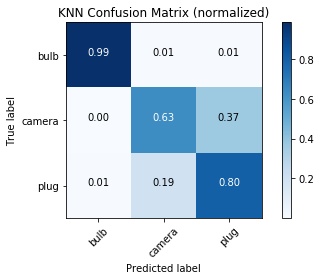

In [140]:
classifier = 'knn'
plot_confusion_matrix(cms[classifier], classes=y_list, title=classifier.upper() + ' Confusion Matrix (normalized)',normalize=True);

Normalized confusion matrix
[[1.         0.         0.        ]
 [0.         0.34687081 0.65312919]
 [0.         0.25080214 0.74919786]]


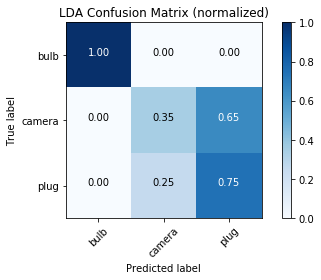

In [141]:
classifier = 'lda'
plot_confusion_matrix(cms[classifier], classes=y_list, title=classifier.upper() + ' Confusion Matrix (normalized)',normalize=True);

Normalized confusion matrix
[[1.         0.         0.        ]
 [0.29040115 0.08356117 0.62603768]
 [0.00695187 0.21016043 0.7828877 ]]


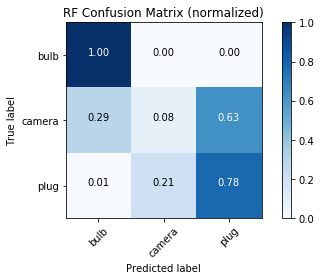

In [142]:
classifier = 'rf'
plot_confusion_matrix(cms[classifier], classes=y_list, title=classifier.upper() + ' Confusion Matrix (normalized)',normalize=True);

## Report metrics

In [147]:
for k,v in metrics.iteritems():
    print k, v

knn (0.8062596783680146, 0.9055652042760667, 0.6544913900230783)
rf (0.6221496225689344, 0.7343424255022107, 0.1637670868098704)
lda (0.6986895555829059, 0.8687754105147412, 0.3960589383987218)
